In [11]:
%matplotlib inline

# Hedge strategy on a given price path
We continue to work within the Black/Scholes model, so the price of the underlying stock follows Geometric Brownian motion as above.

**Task**

Using the scaffold provided, write a Python function which calculates the terminal profit or loss from a strategy which involves selling a European call or put option at time 0 and hedging it by a Black/Scholes delta-hedging strategy with rebalancing at discrete time points, as described in the section "Black/Scholes hedging in practice" of Lecture 5. The function takes six arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$ and a 1 for a call or $-1$ for a put. Note that here, $S$ is a NumPy array of underlying stock prices
$$
S(t_i),\quad 0\leq i\leq n, t_0=0, t_n=T
$$
representing the price of the underlying stock at each time point at which the hedge is rebalanced, as well as the initial time point 0 and the terminal time point $T$, with the latter equal to the time of expiry of the option. 

**Example**
As you can see in the scaffold code, when you run the code, the array of underlying stock prices is read from a file called `stockpath.csv`. In the scaffold, $\sigma$, $r$ and $T$ are set to be consistent with the data in `stockpath.csv`. If your Python function is implemented correctly, you should obtain the following:

`Enter the strike price: 100
Enter 1 for call or -1 for put option: 1
The profit/loss from the hedged option position is 3.7001921391491273`

Note that when your code is marked, there is a tolerance of 0.00001 to allow for cumulative machine precision errors in different implementations.

In [38]:
# Scaffold code
import numpy as np
import pandas as pd
from scipy.stats import norm

def BlackScholesHedgePath(S,K,sgm,r,T,callput):
  
    dt = np.linspace(0, T, len(stock))
    
    d1 = []
    d2 = []
    
    for i, price in enumerate(S[:-1]):
        d1.append((np.log(price/K) + ((r+0.5*sgm**2)*(T - dt[i])))/((sgm*np.sqrt(T - dt[i]))))
        d2.append(d1[-1] - sgm*np.sqrt(T - dt[i]))
        
   
    d1.append(d1[-1])
    d2.append(d2[-1])
    
    pnl = 0
    invested_pnl = 0
    
    for i, price in enumerate(S[1:-1], start = 1):
        if callput == 1:         
            pnl = price*(norm.cdf(d1[i-1]) - norm.cdf(d1[i])) - K*np.exp(-r*(T-dt[i]))*(norm.cdf(d2[i-1]) - norm.cdf(d2[i]))
        else:
            pnl = K*np.exp(-r*(T-dt[i]))*(norm.cdf(-1*d2[i-1]) - norm.cdf(-1*d2[i])) - price*(norm.cdf(-1*d1[i-1] - norm.cdf(-1*d1[i])))
        
        invested_pnl = invested_pnl + (pnl*np.exp(r*(T-dt[i])))
        
        
    if callput ==1:
        pnl = S[-1]*norm.cdf(d1[-1]) - K*norm.cdf(d2[-1]) - max(0, S[-1] - K)
    else:
        pnl = K*norm.cdf(-1*d2[-1]) - S[-1]*norm.cdf(-1*d1[-1]) - max(K - S[-1], 0)
        
    invested_pnl = invested_pnl + pnl
    
    return invested_pnl
    
stockdata = pd.read_csv('stockpath.csv')
stock = np.array(stockdata['S(t)'])
strike = float(input('Enter the strike price: '))
sigma = 0.3
interest = 0.05
maturity = 2
callput = int(input('Enter 1 for call or -1 for put option: '))
PnL = BlackScholesHedgePath(stock,strike,sigma,interest,maturity,callput)
print('The profit/loss from the hedged option position is '+str(PnL))

Enter the strike price: 100
Enter 1 for call or -1 for put option: 1
The profit/loss from the hedged option position is 3.7001921391495167


# Monte Carlo simulation
The goal is to calculate the expected value of a function $f(\cdot)$ of a random variable $x$, where the distribution of $x$ is given by the probability density $\psi(x)$, i.e.
$$
E[f(x)]=\int_{-\infty}^{\infty}f(x)\psi(x)dx
$$

## Outline of the Monte Carlo simulation
1. Establish a procedure for drawing variates $x$ from the target distribution $\psi(x)$.
2. Initialise the variables:
   RunningSum = 0 
   RunningSumSquared = 0 
   $i=1$
3. Draw a realisation $x_i$ from the target distribution.
4. Add $f(x_i)$ to RunningSum and  $(f(x_i))^2$ to RunningSumSquared.
5. Increment the counter $i$. If $i$ is less than the maximum number of iterations, go to step 3.
6. Calculate the simulated mean by dividing RunningSum by the total number of iterations.
7. Calculate the variance of the simulations by dividing RunningSumSquared by the total number of iterations and subtracting the square of the mean.

## Error estimation for Monte Carlo methods
By the Central Limit Theorem, we know that for a large number $N$ of simulations, the simulation mean $X_N$ is approximately normally distributed, with standard deviation
$$
\sqrt{\frac{\sigma^2}N}
$$
where the simulation variance is an estimate for $\sigma^2$.

Thus, if there is no bias, the simulation mean is normally distributed around the target value with a standard deviation, which decreases with $\sqrt{N}$.

A 95% confidence interval for the target value is therefore approximately given by
$$
\left[X_N-2\sqrt{\frac{\sigma^2}N};X_N+2\sqrt{\frac{\sigma^2}N}\right]
$$

<font color='red'>**Monte Carlo simulation without error bounds is meaningless!**</font>

The NumPy function `random.standard_normal()` returns a random variate drawn from the standard normal distribution, while `random.standard_normal(n)` returns `n` such variates in a Numpy array:

In [4]:
import numpy as np
print(np.random.standard_normal())
n = 5
print(np.random.standard_normal(n))

-2.4544089699688127
[-1.11851908  0.25980753  0.42486591  0.47951838 -0.21813699]


Recall that a standard normal random variable can be converted into a normal random variable of desired mean and standard deviation by multiplying by the standard deviation and adding the mean.

## Monte Carlo pricing of a Black/Scholes call option
In the Black/Scholes model, the price of the underlying stock follows Geometric Brownian motion, with the dynamics under the risk-neutral measure given by
$$S(T)=S(t)\exp\left\{\left(r−\frac12\sigma^2\right)(T−t)+\sigma(W(T)−W(t))\right\}$$
Recall that the time 0 price of a European call option (and analogously the put option) expiring at time $T$ with strike price $K$ can be expressed as the expectation under the risk-neutral measure of 
$$C=E\left[e^{−rT}\max(0,S(T)−K)\right]$$
Thus we can write a Python function which calculates the Monte Carlo estimate `MC` for the Black/Scholes price of the option and the standard deviation `MCstd` of the simulation mean, where the function takes seven arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, a 1 for a call or -1 for a put, and $n$, the number of sampling iterations of the Monte Carlo algorithm:

In [5]:
def BlackScholesMC(S,K,sgm,r,T,callput,n):
    w = np.random.standard_normal(n)
    ST=S*np.exp((r-0.5*sgm**2)*T+sgm*np.sqrt(T)*w)
    payoff=callput*(ST-K) 
    payoff=payoff*(payoff>0)
    MC=np.exp(-r*T)*np.mean(payoff)
    MCstd=np.exp(-r*T)*np.std(payoff)/np.sqrt(n)
    return MC, MCstd

To run this code with user inputs:

In [6]:
stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
sigma = float(input('Enter the volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
callput = int(input('Enter 1 for call or -1 for put option: '))
n = int(input('Enter the number of simulations: '))
MC, MCstd = BlackScholesMC(stock,strike,sigma,interest,maturity,callput,n)
print('The MC estimate for the option price is: ')
print(MC)
print('The 2 standard deviation confidence interval for the option price is: ')
print(MC-2*MCstd,MC+2*MCstd)

Enter the underlying stock price: 100
Enter the strike price: 95
Enter the volatility: 0.25
Enter continuously compounded interest rate: 0.05
Enter the time to maturity: 2
Enter 1 for call or -1 for put option: 1
Enter the number of simulations: 100
The MC estimate for the option price is: 
19.643008356826368
The 2 standard deviation confidence interval for the option price is: 
14.134140952052817 25.151875761599918


# Monte Carlo simulation of Black/Scholes hedging
Using the scaffold provided, write a Python function which calculates the Monte Carlo estimate `MC` for the expected terminal profit or loss from a strategy which involves selling a European call or put option at time 0 and hedging it by a Black/Scholes delta-hedging strategy with rebalancing at discrete time points, as described in the section "Black/Scholes hedging in practice" of Lecture 5. The function should also return the standard deviation `MCstd` of the simulation mean. The function takes nine arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, a 1 for a call or $-1$ for a put, the drift $\mu$ of the stock price process under the objective (not the risk-neutral) probability measure, the number of sampling iterations of the Monte Carlo algorithm $n$, and the number of time steps $m$ on each simulated price path. 

Note that here $S$ is the initial (time 0) stock price, and your function needs to generate $n$ sample paths of the stock price dynamics unter the objective probability measure, i.e. according to the dynamics
$$
S(T)=S(t)\exp\left\{(μ−\frac12\sigma^2)(T−t)+\sigma(W(T)−W(t))\right\}
$$
This reflects the fact that this is a risk management application, not a pricing application, so we are interested in the uncertainty of the terminal profit/loss under the objective probabilities.

Enter the underlying stock price: 100
Enter the strike price: 105
Enter the volatility: 0.3
Enter continuously compounded interest rate: 0.02
Enter the time to maturity: 1
Enter 1 for call or -1 for put option: 1
Enter the drift mu: 0.07
Enter the number of simulations: 10000
Enter the number of time steps: 100


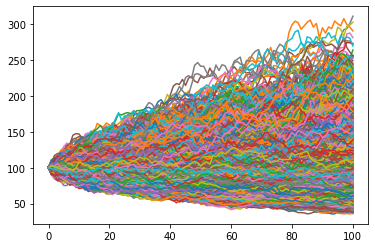

The average simulated profit/loss is: 
-0.0051624161784205765
The 2 standard deviation confidence interval for the mean profit/loss is: 
-0.026595608750856595 0.016270776394015442


In [21]:
# Scaffold code
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def BlackScholesHedgeMC(S,K,sgm,r,T,callput,mu,n,m):
    # your code here
    
    t = np.linspace(0, T, int(m) + 1)
    dt = T/m
    
    St = pd.DataFrame(0., index=range(0, m+1), columns=list(range(0,n)))
    
    d1 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    d2 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    pnl = pd.DataFrame(0, index=range(1, m+1), columns=list(range(0, n)))
    
    St.iloc[0] = S
    
    for i in range(1, m+1):
        w = np.random.standard_normal(n)
        
        St.iloc[i] = St.iloc[i-1]*np.exp((mu - 0.5*sgm**2)*dt + sgm*np.sqrt(dt)*w)
        
    plt.plot(St)
    plt.show()
    
    for i in range(0, m):
        d1.iloc[i] = (np.log(St.iloc[i]/K) + ((r+0.5*sgm**2)) * (T-t[i]))/(sgm*np.sqrt(T-t[i]))
        d2.iloc[i] = d1.iloc[i] - sgm*np.sqrt(T-t[i])
        
    for i in range(1, m+1):
        if callput == 1:
            pnl.iloc[i-1] = (St.iloc[i]*(norm.cdf(d1.iloc[i-1]) - norm.cdf(d1.iloc[i]))
                               - K*np.exp(-r*(T-t[i]))*(norm.cdf(d2.iloc[i-1]) - norm.cdf(d2.iloc[i])))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = St.iloc[-1]*norm.cdf(d1.iloc[-2]) - K*norm.cdf(d2.iloc[-2]) - np.maximum(0, St.iloc[-1] - K)
        
        elif callput == -1:
            pnl.iloc[i-1] = ((K*np.exp(-r*(T-t[i])) * (norm.cdf(-1*d2.iloc[i-1]) - norm.cdf(-1*d2.iloc[i]))) - 
            (St.iloc[i]*(norm.cdf(-1*d1.iloc[i-1]) - norm.cdf(-1*d1.iloc[i]))))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = (K * norm.cdf(-1*d2.iloc[-2])) - (St.iloc[-1] * norm.cdf(-1*d1.iloc[-2])) - (np.maximum(K - St.iloc[-1], 0))

    pnl = pnl.fillna(0)
    
    cum_pnl = np.sum(pnl )
    
    MC = np.mean(cum_pnl)
    MCstd = np.std(cum_pnl/np.sqrt(n))

      
    return MC, MCstd

stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
sigma = float(input('Enter the volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
callput = int(input('Enter 1 for call or -1 for put option: '))
mu = float(input('Enter the drift mu: '))
n = int(input('Enter the number of simulations: '))
m = int(input('Enter the number of time steps: '))
MC, MCstd = BlackScholesHedgeMC(stock,strike,sigma,interest,maturity,callput,mu,n,m)
print('The average simulated profit/loss is: ')
print(MC)
print('The 2 standard deviation confidence interval for the mean profit/loss is: ')
print(MC-2*MCstd,MC+2*MCstd)

# Visualising the profit/loss distribution
Adapt the Monte Carlo code you have written to generate the data for plotting a histogram of the profit/loss distribution of the hedged position, allowing for the same set of user inputs as in the above example. Plot the histogram.

Enter the underlying stock price: 100
Enter the strike price: 105
Enter the volatility: 0.3
Enter continuously compounded interest rate: 0.02
Enter the time to maturity: 1
Enter 1 for call or -1 for put option: 1
Enter the drift mu: 0.07
Enter the number of simulations: 10000
Enter the number of time steps: 100


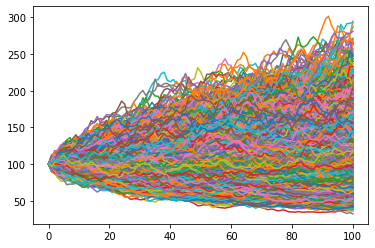

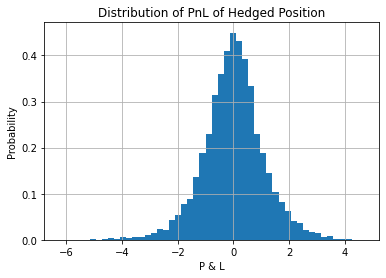

The average simulated profit/loss is: 
0.0024404766991064993
The 2 standard deviation confidence interval for the mean profit/loss is: 
-0.01940332297684835 0.024284276375061347


In [20]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

def BlackScholesHedgeMC(S,K,sgm,r,T,callput,mu,n,m):
    # your code here
    
    t = np.linspace(0, T, int(m) + 1)
    dt = T/m
    
    St = pd.DataFrame(0., index=range(0, m+1), columns=list(range(0,n)))
    
    d1 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    d2 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    pnl = pd.DataFrame(0, index=range(1, m+1), columns=list(range(0, n)))
    
    St.iloc[0] = S
    
    for i in range(1, m+1):
        w = np.random.standard_normal(n)
        
        St.iloc[i] = St.iloc[i-1]*np.exp((mu - 0.5*sgm**2)*dt + sgm*np.sqrt(dt)*w)
        
    plt.plot(St)
    plt.show()
    
    for i in range(0, m):
        d1.iloc[i] = (np.log(St.iloc[i]/K) + ((r+0.5*sgm**2)) * (T-t[i]))/(sgm*np.sqrt(T-t[i]))
        d2.iloc[i] = d1.iloc[i] - sgm*np.sqrt(T-t[i])
        
    for i in range(1, m+1):
        if callput == 1:
            pnl.iloc[i-1] = (St.iloc[i]*(norm.cdf(d1.iloc[i-1]) - norm.cdf(d1.iloc[i]))
                               - K*np.exp(-r*(T-t[i]))*(norm.cdf(d2.iloc[i-1]) - norm.cdf(d2.iloc[i])))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = St.iloc[-1]*norm.cdf(d1.iloc[-2]) - K*norm.cdf(d2.iloc[-2]) - np.maximum(0, St.iloc[-1] - K)
        
        elif callput == -1:
            pnl.iloc[i-1] = ((K*np.exp(-r*(T-t[i])) * (norm.cdf(-1*d2.iloc[i-1]) - norm.cdf(-1*d2.iloc[i]))) - 
            (St.iloc[i]*(norm.cdf(-1*d1.iloc[i-1]) - norm.cdf(-1*d1.iloc[i]))))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = (K * norm.cdf(-1*d2.iloc[-2])) - (St.iloc[-1] * norm.cdf(-1*d1.iloc[-2])) - (np.maximum(K - St.iloc[-1], 0))

    pnl = pnl.fillna(0)
    
    cum_pnl = np.sum(pnl)
    
    MC = np.mean(cum_pnl)
    MCstd = np.std(cum_pnl/np.sqrt(n))

    plt.title("Distribution of PnL of Hedged Position")
    plt.hist(cum_pnl, density=True, bins=50)
    plt.ylabel('Probability')
    plt.xlabel('P & L')
    plt.grid('on')
    plt.show()

    print('The average simulated profit/loss is: ')
    print(MC)
    print('The 2 standard deviation confidence interval for the mean profit/loss is: ')
    print(MC-2*MCstd,MC+2*MCstd)
    
stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
sigma = float(input('Enter the volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
callput = int(input('Enter 1 for call or -1 for put option: '))
mu = float(input('Enter the drift mu: '))
n = int(input('Enter the number of simulations: '))
m = int(input('Enter the number of time steps: '))
BlackScholesHedgeMC(stock,strike,sigma,interest,maturity,callput,mu,n,m)

# Analysing the profit/loss distribution
Using the code you have written (adapting it if necessary), please answer the following questions:
<OL>
    <LI>What happens to the profit/loss (P/L) distribution of the hedged position when you increase or decrease the number of time steps? Why do you think this is so?</LI>
    <LI>What happens to P/L distribution if you change $\mu$ in the objective measure dynamics? Why do you think this is so?</LI>
    <LI>What happens to P/L distribution if you hedge based on a lower volatility than you use to generate the Monte Carlo paths? If you hedge using a higher volatility? Why do you think this is so?</LI>
</OL>
Please add code and "Markdown" cells for your code and text answers below - <font color='red'>**remember not to overwrite your answers to previous questions above!**</font> 

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

def BlackScholesHedgeMC(S,K,sgm,r,T,callput,mu,n,m):
    # your code here
    
    t = np.linspace(0, T, int(m) + 1)
    dt = T/m
    
    St = pd.DataFrame(0., index=range(0, m+1), columns=list(range(0,n)))
    
    d1 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    d2 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    pnl = pd.DataFrame(0, index=range(1, m+1), columns=list(range(0, n)))
    
    St.iloc[0] = S
    
    for i in range(1, m+1):
        w = np.random.standard_normal(n)
        
        St.iloc[i] = St.iloc[i-1]*np.exp((mu - 0.5*sgm**2)*dt + sgm*np.sqrt(dt)*w)
        
    
    for i in range(0, m):
        d1.iloc[i] = (np.log(St.iloc[i]/K) + ((r+0.5*sgm**2)) * (T-t[i]))/(sgm*np.sqrt(T-t[i]))
        d2.iloc[i] = d1.iloc[i] - sgm*np.sqrt(T-t[i])
        
    for i in range(1, m+1):
        if callput == 1:
            pnl.iloc[i-1] = (St.iloc[i]*(norm.cdf(d1.iloc[i-1]) - norm.cdf(d1.iloc[i]))
                               - K*np.exp(-r*(T-t[i]))*(norm.cdf(d2.iloc[i-1]) - norm.cdf(d2.iloc[i])))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = St.iloc[-1]*norm.cdf(d1.iloc[-2]) - K*norm.cdf(d2.iloc[-2]) - np.maximum(0, St.iloc[-1] - K)
        
        elif callput == -1:
            pnl.iloc[i-1] = ((K*np.exp(-r*(T-t[i])) * (norm.cdf(-1*d2.iloc[i-1]) - norm.cdf(-1*d2.iloc[i]))) - 
            (St.iloc[i]*(norm.cdf(-1*d1.iloc[i-1]) - norm.cdf(-1*d1.iloc[i]))))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = (K * norm.cdf(-1*d2.iloc[-2])) - (St.iloc[-1] * norm.cdf(-1*d1.iloc[-2])) - (np.maximum(K - St.iloc[-1], 0))

    pnl = pnl.fillna(0)
    
    cum_pnl = np.sum(pnl)
    
    return cum_pnl

### 1. What happens to the profit/loss (P/L) distribution of the hedged position when you increase or decrease the number of time steps? Why do you think this is so?

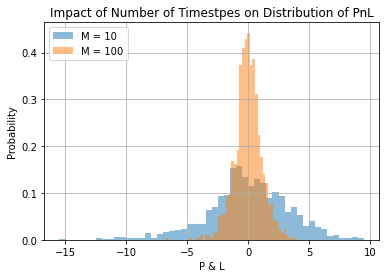

In [12]:
less_timesteps = BlackScholesHedgeMC(100,95,0.25,0.05,2,1,0.07,1000,10)
more_timesteps = BlackScholesHedgeMC(100,95,0.25,0.05,2,1,0.07,1000,100)

plt.title("Impact of Number of Timestpes on Distribution of PnL")
plt.hist(less_timesteps, density=True, bins=50, alpha=0.5, label="M = 10")
plt.hist(more_timesteps, density=True, bins=50, alpha=0.5, label="M = 100")
plt.ylabel('Probability')
plt.xlabel('P & L')
plt.grid('on')
plt.legend(loc='upper left')
plt.show()

When increasing the number of time steps taken when hedging our portfolio to M = 100 we observe that the distribution becomes significantly more peaked around the mean, the variance has decreased dramatically and therefore shows positive kurtosis. On the other hand, this implies that as we hedge less frequently, the frequency of large gains and large losses increases and the tails of the distribution become fatter (negative kurtosis) which is exactly what we observe when M = 10. This change in distributions is due to the fact that gains and losses in the portfolio are accumulated continuously whereas the portfolio is being hedged in a discrete fashion. Therefore by increasing the number of timesteps taken when hedging, we approach the continuous limit that is proposed by the Black-Scholes model and the hedged portfolio at each step is closer to matching the instantaneous changes in the portfolio. 

### 2. What happens to P/L distribution if you change  𝜇  in the objective measure dynamics? Why do you think this is so?

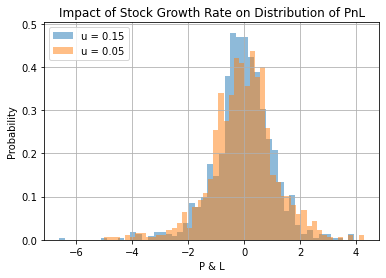

In [14]:
higher_growth = BlackScholesHedgeMC(100,95,0.25,0.05,2,1,0.15,1000,100)
lower_growth = BlackScholesHedgeMC(100,95,0.25,0.05,2,1,0.05,1000,100)

plt.title("Impact of Stock Growth Rate on Distribution of PnL")
plt.hist(higher_growth, density=True, bins=50, alpha=0.5, label="u = 0.15")
plt.hist(lower_growth, density=True, bins=50, alpha=0.5, label="u = 0.05")
plt.ylabel('Probability')
plt.xlabel('P & L')
plt.grid('on')
plt.legend(loc='upper left')
plt.show()

When increasing the growth rate of the stock under the objective measure we observe no significant changes in the distribution of the profit and loss of the hedged portfolio. When delta hedging an option on a single underlying, we are taking advantage of the perfect correlation between changes in the stock price and the resulting changes in the option price to create a risk-free portfolio:

$$V(t,S) = -f(t,S) + \Delta S(t)$$

This dynamic between stock price and option price is represented by the option delta , and by taking an opposite position in the stock to the one we have in the option that is equal to the delta times the stock price at each timestep we are nullifying any risk associated with the growth in the stock price. This means that by holding this delta position in the underlying stock, we are removing the stochastic diffusion term of the portfolio dynamics governed by the increments of Brownian motion and therefore resulting in a deterministic average growth rate in the portfolio equal to the risk-free rate r:

$$dV(t,S) = rVdt = r(\Delta S - f)dt = Q_f(\theta + \frac{1}{2}\sigma^2S^2\Gamma)dt$$

The change in the hedged portfolio is now only exposed to the option’s theta, gamma, and the volatility. Therefore, changes in the growth rate of the stock should have no statistically significant impact on the total PnL of the portfolio.

### 3. What happens to P/L distribution if you hedge based on a lower volatility than you use to generate the Monte Carlo paths? If you hedge using a higher volatility? Why do you think this is so?

In [25]:
def BlackScholesHedgeMC(S,K,sgm1,sgm2,r,T,callput,mu,n,m):
    # your code here
    
    t = np.linspace(0, T, int(m) + 1)
    dt = T/m
    
    St = pd.DataFrame(0., index=range(0, m+1), columns=list(range(0,n)))
    
    d1 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    d2 = pd.DataFrame(0, index=range(0, m+1), columns=list(range(0, n)))
    pnl = pd.DataFrame(0, index=range(1, m+1), columns=list(range(0, n)))
    
    St.iloc[0] = S
    
    for i in range(1, m+1):
        w = np.random.standard_normal(n)
        
        St.iloc[i] = St.iloc[i-1]*np.exp((mu - 0.5*sgm1**2)*dt + sgm1*np.sqrt(dt)*w)
        
    
    for i in range(0, m):
        d1.iloc[i] = (np.log(St.iloc[i]/K) + ((r+0.5*sgm2**2)) * (T-t[i]))/(sgm2*np.sqrt(T-t[i]))
        d2.iloc[i] = d1.iloc[i] - sgm2*np.sqrt(T-t[i])
        
    for i in range(1, m+1):
        if callput == 1:
            pnl.iloc[i-1] = (St.iloc[i]*(norm.cdf(d1.iloc[i-1]) - norm.cdf(d1.iloc[i]))
                               - K*np.exp(-r*(T-t[i]))*(norm.cdf(d2.iloc[i-1]) - norm.cdf(d2.iloc[i])))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = St.iloc[-1]*norm.cdf(d1.iloc[-2]) - K*norm.cdf(d2.iloc[-2]) - np.maximum(0, St.iloc[-1] - K)
        
        elif callput == -1:
            pnl.iloc[i-1] = ((K*np.exp(-r*(T-t[i])) * (norm.cdf(-1*d2.iloc[i-1]) - norm.cdf(-1*d2.iloc[i]))) - 
            (St.iloc[i]*(norm.cdf(-1*d1.iloc[i-1]) - norm.cdf(-1*d1.iloc[i]))))*np.exp(r*(T-t[i]))
            
            pnl.iloc[-1] = (K * norm.cdf(-1*d2.iloc[-2])) - (St.iloc[-1] * norm.cdf(-1*d1.iloc[-2])) - (np.maximum(K - St.iloc[-1], 0))

    pnl = pnl.fillna(0)
    
    cum_pnl = np.sum(pnl)
    
    return cum_pnl

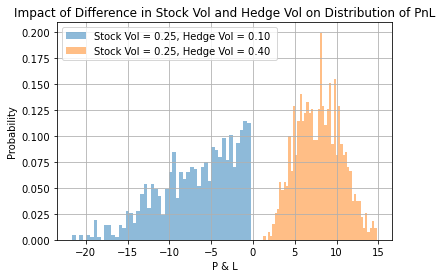

In [28]:
lower_vol = BlackScholesHedgeMC(100,95,0.25,0.10,0.05,2,1,0.07,1000,100)
higher_vol = BlackScholesHedgeMC(100,95,0.25,0.40,0.05,2,1,0.07,1000,100)

plt.title("Impact of Difference in Stock Vol and Hedge Vol on Distribution of PnL")
plt.hist(lower_vol, density=True, bins=50, alpha=0.5, label="Stock Vol = 0.25, Hedge Vol = 0.10 ")
plt.hist(higher_vol, density=True, bins=50, alpha=0.5, label="Stock Vol = 0.25, Hedge Vol = 0.40")
plt.ylabel('Probability')
plt.xlabel('P & L')
plt.grid('on')
plt.legend(loc='upper left')
plt.show()

When hedging based on a higher volatility than is realised by the stock process, the PnL distribution is strictly positive and relatively gaussian. On the other hand, hedging with a lower volatility than is realised by the stock process results in a strictly negative PnL distribution with a large negative skew. The differences in distributions is due to the fact that as the option seller, and when hedging with a higher volatility relative to the realised  stock process, we are in essence selling an overpriced option and hedging away the risk from the underlying and therefore collecting a profit as the option moves towards its market value where realized vol = implied vol, resulting in a positive PnL distribution. The opposite is true when hedging with a volitility that is below the realised volatility of the stock path, as we are essentially selling an underpriced option and are on the wrong side of the trade as the option moves towards the market price, resulting in a negative PnL distribution. 